In [4]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import nilearn

import keras
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display
from keras_tqdm import TQDMNotebookCallback

In [5]:
# My code posted 'fmri preprocessing' shows you how to obtain This YData
# it is just a list of whether the person is schizophrenic or not using one hot encoding

YData = np.load('/Users/KJP/Desktop/neural nets/Codes/YData.npy')

In [14]:
# fetch dataset
dataset = nilearn.datasets.fetch_cobre(n_subjects=146, data_dir="/Users/KJP/Desktop/neural nets/Cobre Dataset2", url=None, verbose=1)
file_paths = dataset["func"]  #list of file names
confounds = dataset["confounds"]  #list of confound file names
file_paths.sort() #sort file names by alphabetical order, which will result in sorting by patient number
confounds.sort()
del file_paths[74]                           # number 74 is misisng samples so it needs to be removed
del confounds[74]

In [15]:
# This function is just used for some plots later on in the code

n_subjects = 145  # subjects to consider for group-sparse covariance (max: 40)
from nilearn import plotting

def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing. """

    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plotting.plot_matrix(cov, cmap=plotting.cm.bwr,
                         vmin=-1, vmax=1, title="%s / covariance" % title,
                         labels=labels)
    # Display precision matrix
    plotting.plot_matrix(prec, cmap=plotting.cm.bwr,
                         vmin=-span, vmax=span, title="%s / precision" % title,
                         labels=labels)


In [16]:
# this is a brain anatomical atlas template, that gives us brain reigons with their labels
from nilearn import datasets
msdl_atlas_dataset = datasets.fetch_atlas_msdl()

In [ ]:
from nilearn import image
from nilearn import input_data

# A "memory" to avoid recomputation
from sklearn.externals.joblib import Memory
mem = Memory('nilearn_cache')

# mask the data, used the atlas template as the mask img.
masker = input_data.NiftiMapsMasker(
    msdl_atlas_dataset.maps, resampling_target="maps", detrend=True,
    low_pass=None, high_pass=0.01, t_r=2.0, standardize=True,
    memory='nilearn_cache', memory_level=1, verbose=2)
masker.fit()

# for each of our fmri scams, compute confounds, transform them into mask, and append
# to time series list
subject_time_series = []
for file_paths, confounds in zip(file_paths, confounds):
    print("Processing file %s" % file_paths)

    # Computing some confounds
    hv_confounds = mem.cache(image.high_variance_confounds)(
        file_paths)

    region_ts = masker.transform(file_paths,
                                 confounds=[hv_confounds, confounds])
    subject_time_series.append(region_ts)

In [ ]:
# For now, we only use GroupSparseCovariance in the Neural Network
# GraphlassoCV is a very similar algorithm and it is also shown to compare, 
# but isn't used in the Neural net
from nilearn.connectome import GroupSparseCovarianceCV 
gsc = GroupSparseCovarianceCV(verbose=2)
gsc.fit(subject_time_series)

from sklearn import covariance                  #<-- this part isnt used in neural net
gl = covariance.GraphLassoCV(verbose=2)
gl.fit(np.concatenate(subject_time_series))

/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


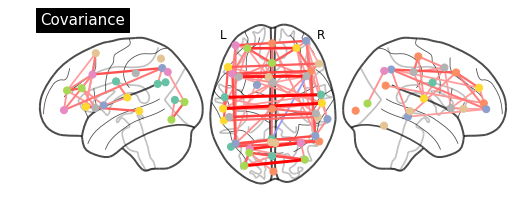

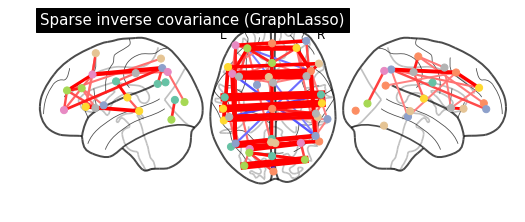

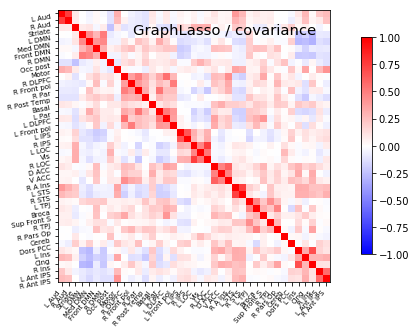

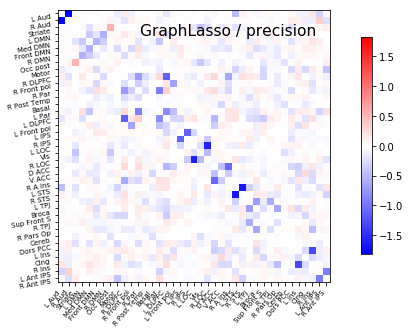

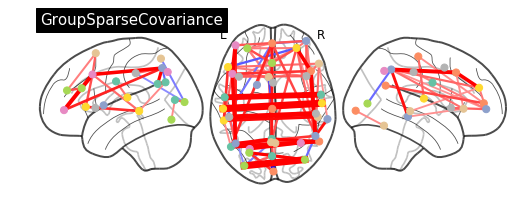

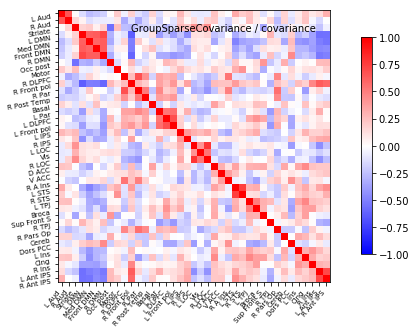

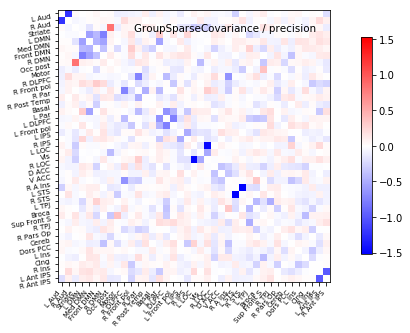

In [19]:
# Plot the correlation matrices and their corresponding connectomes
atlas_img = msdl_atlas_dataset.maps
atlas_region_coords = nilearn.plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = msdl_atlas_dataset.labels

plotting.plot_connectome(gl.covariance_,
                         atlas_region_coords, edge_threshold='90%',
                         title="Covariance",
                         display_mode="lzr")
plotting.plot_connectome(-gl.precision_, atlas_region_coords,
                         edge_threshold='90%',
                         title="Sparse inverse covariance (GraphLasso)",
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gl.covariance_, gl.precision_, "GraphLasso", labels)

title = "GroupSparseCovariance"
plotting.plot_connectome(-gsc.precisions_[..., 0],
                         atlas_region_coords, edge_threshold='90%',
                         title=title,
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gsc.covariances_[..., 0],
              gsc.precisions_[..., 0], title, labels)

plotting.show()

In [124]:
covar = gsc.covariances_
covar= covar.reshape(covar.shape[0]*covar.shape[1],covar.shape[2])
covar = np.swapaxes(covar, 0, 1)

In [125]:
X = covar

In [126]:
x_train = X[20:]
x_test = X[:20]
y_train = YData[20:]
y_test = YData[:20]
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(125, 1521)
(125, 2)
(20, 2)
(20, 1521)


In [127]:
input_dim=x_train.shape[1]
output_dim=2
# Multi-layer net with ReLU hidden layer
model = keras.models.Sequential()
# Here we make the hidden layer (size 2) with a ReL
# activation function, but also initialize the bias
# weights in the network to a constant 0.1
model.add(keras.layers.Dropout(0.05, input_shape=(input_dim,)))
model.add(keras.layers.Dense(300,activation='relu',
                            bias_initializer=keras.initializers.Constant(0.1)))
#model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10,input_dim=input_dim,activation='relu',
                            bias_initializer=keras.initializers.Constant(0.1)))


# Output layer (size 1), sigmoid activation function
model.add(keras.layers.Dense(output_dim,activation='softmax'))
# Compile as above (default learning rate and other
# hyperparameters for the Adam optimizer).
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.00002), metrics=['accuracy'])
# Display the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_23 (Dropout)         (None, 1521)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 300)               456600    
_________________________________________________________________
dense_44 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 22        
Total params: 459,632
Trainable params: 459,632
Non-trainable params: 0
_________________________________________________________________
None


In [128]:
batch_size = 110
epochs = 300
history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2)

Train on 100 samples, validate on 25 samples
Epoch 1/300
100/100 [==============================] - 1s 9ms/step - loss: 0.7948 - acc: 0.5100 - val_loss: 1.0623 - val_acc: 0.2800
Epoch 2/300
100/100 [==============================] - 0s 194us/step - loss: 0.7726 - acc: 0.5000 - val_loss: 1.0331 - val_acc: 0.2800
Epoch 3/300
100/100 [==============================] - 0s 257us/step - loss: 0.7830 - acc: 0.5100 - val_loss: 1.0076 - val_acc: 0.2800
Epoch 4/300
100/100 [==============================] - 0s 269us/step - loss: 0.7609 - acc: 0.5100 - val_loss: 0.9810 - val_acc: 0.2400
Epoch 5/300
100/100 [==============================] - 0s 259us/step - loss: 0.7417 - acc: 0.5100 - val_loss: 0.9561 - val_acc: 0.2400
Epoch 6/300
100/100 [==============================] - 0s 239us/step - loss: 0.7297 - acc: 0.5300 - val_loss: 0.9330 - val_acc: 0.2400
Epoch 7/300
100/100 [==============================] - 0s 170us/step - loss: 0.7363 - acc: 0.5100 - val_loss: 0.9113 - val_acc: 0.2800
Epoch 8/300


Epoch 61/300
100/100 [==============================] - 0s 233us/step - loss: 0.4619 - acc: 0.9100 - val_loss: 0.7289 - val_acc: 0.5600
Epoch 62/300
100/100 [==============================] - 0s 181us/step - loss: 0.4650 - acc: 0.9100 - val_loss: 0.7275 - val_acc: 0.5600
Epoch 63/300
100/100 [==============================] - 0s 178us/step - loss: 0.4510 - acc: 0.8900 - val_loss: 0.7261 - val_acc: 0.6000
Epoch 64/300
100/100 [==============================] - 0s 236us/step - loss: 0.4531 - acc: 0.9300 - val_loss: 0.7249 - val_acc: 0.6000
Epoch 65/300
100/100 [==============================] - 0s 181us/step - loss: 0.4455 - acc: 0.9400 - val_loss: 0.7240 - val_acc: 0.6000
Epoch 66/300
100/100 [==============================] - 0s 178us/step - loss: 0.4440 - acc: 0.9300 - val_loss: 0.7229 - val_acc: 0.6000
Epoch 67/300
100/100 [==============================] - 0s 232us/step - loss: 0.4453 - acc: 0.9300 - val_loss: 0.7219 - val_acc: 0.6000
Epoch 68/300
100/100 [==========================

100/100 [==============================] - 0s 287us/step - loss: 0.2847 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.5600
Epoch 122/300
100/100 [==============================] - 0s 270us/step - loss: 0.2913 - acc: 0.9900 - val_loss: 0.6693 - val_acc: 0.5600
Epoch 123/300
100/100 [==============================] - 0s 236us/step - loss: 0.2790 - acc: 1.0000 - val_loss: 0.6691 - val_acc: 0.5600
Epoch 124/300
100/100 [==============================] - 0s 466us/step - loss: 0.2789 - acc: 0.9800 - val_loss: 0.6689 - val_acc: 0.5600
Epoch 125/300
100/100 [==============================] - 0s 321us/step - loss: 0.2849 - acc: 0.9900 - val_loss: 0.6688 - val_acc: 0.5600
Epoch 126/300
100/100 [==============================] - 0s 313us/step - loss: 0.2751 - acc: 0.9800 - val_loss: 0.6684 - val_acc: 0.5600
Epoch 127/300
100/100 [==============================] - 0s 200us/step - loss: 0.2828 - acc: 0.9800 - val_loss: 0.6681 - val_acc: 0.5600
Epoch 128/300
100/100 [==============================] 

Epoch 181/300
100/100 [==============================] - 0s 143us/step - loss: 0.1773 - acc: 1.0000 - val_loss: 0.6535 - val_acc: 0.6400
Epoch 182/300
100/100 [==============================] - 0s 214us/step - loss: 0.1795 - acc: 1.0000 - val_loss: 0.6533 - val_acc: 0.6400
Epoch 183/300
100/100 [==============================] - 0s 163us/step - loss: 0.1763 - acc: 1.0000 - val_loss: 0.6533 - val_acc: 0.6400
Epoch 184/300
100/100 [==============================] - 0s 252us/step - loss: 0.1735 - acc: 1.0000 - val_loss: 0.6530 - val_acc: 0.6400
Epoch 185/300
100/100 [==============================] - 0s 172us/step - loss: 0.1794 - acc: 1.0000 - val_loss: 0.6525 - val_acc: 0.6400
Epoch 186/300
100/100 [==============================] - 0s 214us/step - loss: 0.1713 - acc: 1.0000 - val_loss: 0.6520 - val_acc: 0.6400
Epoch 187/300
100/100 [==============================] - 0s 237us/step - loss: 0.1767 - acc: 1.0000 - val_loss: 0.6515 - val_acc: 0.6400
Epoch 188/300
100/100 [==================

Epoch 241/300
100/100 [==============================] - 0s 235us/step - loss: 0.1166 - acc: 1.0000 - val_loss: 0.6490 - val_acc: 0.6400
Epoch 242/300
100/100 [==============================] - 0s 197us/step - loss: 0.1148 - acc: 1.0000 - val_loss: 0.6489 - val_acc: 0.6400
Epoch 243/300
100/100 [==============================] - 0s 222us/step - loss: 0.1141 - acc: 1.0000 - val_loss: 0.6488 - val_acc: 0.6400
Epoch 244/300
100/100 [==============================] - 0s 228us/step - loss: 0.1157 - acc: 1.0000 - val_loss: 0.6492 - val_acc: 0.6400
Epoch 245/300
100/100 [==============================] - 0s 176us/step - loss: 0.1192 - acc: 1.0000 - val_loss: 0.6494 - val_acc: 0.6800
Epoch 246/300
100/100 [==============================] - 0s 221us/step - loss: 0.1107 - acc: 1.0000 - val_loss: 0.6497 - val_acc: 0.6800
Epoch 247/300
100/100 [==============================] - 0s 201us/step - loss: 0.1109 - acc: 1.0000 - val_loss: 0.6502 - val_acc: 0.6800
Epoch 248/300
100/100 [==================

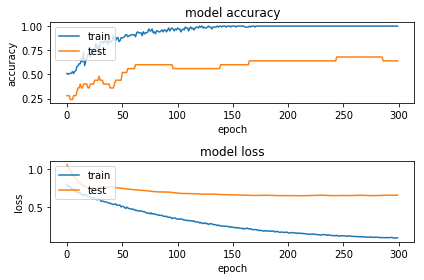

In [129]:
plt.figure()
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [131]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.485856294631958
Test accuracy: 0.75
